# Amazon Fine Food Reviews Analysis

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [ ]:
import numpy as np 
import pandas as pd 
import spacy
import sklearn
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import spearmanr
!pip install scattertext
import scattertext as st

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 133kB 2.7MB/s 
     |████████████████████████████████| 7.2MB 2.6MB/s 


In [ ]:
# Mount storage fro google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We load the data and then do some very high level overview of what this dataset looks like.

In [ ]:
# Load dataset
reviews = pd.read_csv("/content/drive/My Drive/kaggle/amazon-fine-food-reviews/Reviews.csv")

In [ ]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


We can get a general idea of what idea is available. We can see `ProductId` which might be interesting to either aggregate reviews against a single product or maybe pulling additional metadata from Amazon on what those products are. We have `UserId` and `ProfileName` which are both the reviewer. Some obscure things you can do with it is maybe see how the `UserId` can change overtime as `ProfileName` can be changed. What would be directly interesting would be to try to track the evolution of reviews of the frequent reviewers. We have several columns for other people rating the reviews. We also have `Score` which is what the reviewer rated a product. `Time` is in timestamp string format and needs to be converted to be able to do longitudinal analysis. Finally, `Summary` and `Text` are the columns which refer to the tag line and actual summary of the text.

We can get an alternative view of the data by getting summary statistics.

In [ ]:
reviews.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


From here, we can see that the `score` seems to be between 1 and 5 which is expected. Additionally, most of the reviews are right skewed in it's helpfulness with some very strong outliers. The helpfulness columns will need to be normalized in order to be useful. 

In [ ]:
reviews.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Finally, we can look at the number of missing data in this dataset. It looks like most of the data is filled in with some exceptions in the profile name and summary. 

## EDA

### Feature Engineering

#### Helpfulness

First, we can do some minor feature engineering. We can get the percentage of and rescale the helpfulness by dividing the numerator by the denominator.

In [ ]:
# Calculate the Helpfulness percentage
reviews["Helpfulness"] = reviews["HelpfulnessNumerator"]/reviews["HelpfulnessDenominator"]
reviews['Helpfulness'].fillna(0) # Divide by 0 for non helpful reviews
reviews["Helpfulness"].mean()

0.776974535871338

#### Review lengths

We can look into the review lengths as this could be a simple metric related to the score of the reviews. For instance, longer reviews might be more passionate so it could have a higher score and vice versa. First, we need to impute the missing summary titles with blanks.

In [ ]:
# Impute missing titles with ''
reviews["Summary"] = reviews["Summary"].fillna('')

Then we can calculate the lengths of the text.

In [ ]:
# Calculate summary lengths
reviews["Summary_length"] = reviews["Summary"].map(lambda x: len(x.split()))

# Calculate review lengths
reviews["Text_length"] = reviews["Text"].map(lambda x: len(x.split()))

#### Timestamps

The timestamps need to be fixed in order to use them. 

In [ ]:
reviews["Time"] = pd.to_datetime(reviews.Time,  unit='s')
reviews["Time"]

0        2011-04-27
1        2012-09-07
2        2008-08-18
3        2011-06-13
4        2012-10-21
            ...    
568449   2011-03-09
568450   2012-03-09
568451   2012-02-21
568452   2012-03-13
568453   2012-05-31
Name: Time, Length: 568454, dtype: datetime64[ns]

#### Sentiment Score

It would be interesting to try to correlate the sentiment of a review against the score. We can use [Vader](https://github.com/cjhutto/vaderSentiment) which is a rules based approach to classifying the reviews. 

In [ ]:
# Init the Sentiment analyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
# Scorer based on cutoffs suggested by paper
def score_sentiment(compound_score):
    if compound_score >= 0.05:
        return("Positive")
    elif compound_score < 0.05 and compound_score >= -0.05:
        return("Neutral")
    else:
        return("Negative")

reviews["Text_sentiment"] = reviews["Text"].map(lambda x: score_sentiment(analyser.polarity_scores(x)['compound']))
reviews["Summary_sentiment"] = reviews["Summary"].map(lambda x: score_sentiment(analyser.polarity_scores(x)['compound']))

### Stats

First, we can look at the distributions of all of the variables to get an idea of what this dataset looks like. 

#### Reviews over time

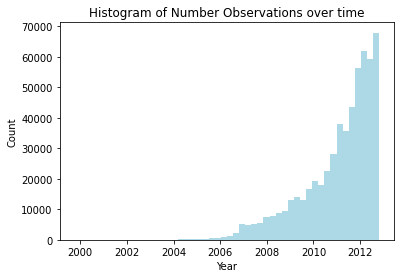

In [ ]:
# Plot number of reviews overtime
plt.hist(reviews["Time"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Histogram of Number Observations over time')
plt.show()

We can see in the plot above that the number of reviews in this dataset exponentially grew over the years up to 2012.

In [ ]:
pd.DatetimeIndex(reviews['Time']).year.value_counts()

2012    198659
2011    163299
2010     85884
2009     55326
2008     34163
2007     22300
2006      6671
2005      1335
2004       561
2003       132
2002        73
2000        32
2001        13
1999         6
Name: Time, dtype: int64

Looking at the raw values, we can see that the dataset starts from 1999-2012. 2001 and 2000 are likely mislabeled in this case as it doesn't make sense exponential growth wise but as that time was roughly around the dot com bubble bursting, it could be plausible and will be left alone.

In [ ]:
pd.DatetimeIndex(reviews['Time']).year == '2000'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



array([False, False, False, ..., False, False, False])

#### Score count

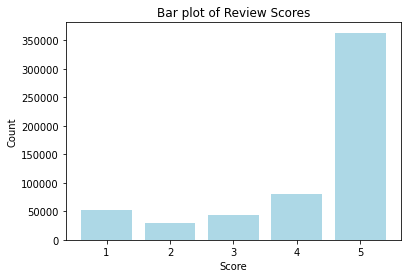

In [ ]:
# Plot number of scores 
score_counts = reviews["Score"].value_counts().to_dict()
plt.bar(score_counts.keys(), height=score_counts.values(), color='lightblue')
plt.ylabel('Count')
plt.xlabel('Score')
plt.title('Bar plot of Review Scores')
plt.show()

Most of the reviews are 5 stars. If modeling, this will be an issue.

#### Sentiment Distribution

As we have the sentiment of the text and summary, we can see roughly what the predicted sentiments are. 

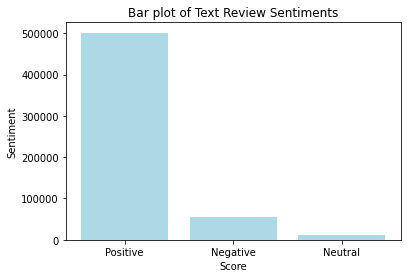

In [ ]:
text_sentiment_counts = reviews["Text_sentiment"].value_counts().to_dict()
plt.bar(text_sentiment_counts.keys(), height=text_sentiment_counts.values(), color='lightblue')
plt.ylabel('Sentiment')
plt.xlabel('Score')
plt.title('Bar plot of Text Review Sentiments')
plt.show()

Most of the reviews are considered postiive. This is somewhat expected as most of the reviews have 5 stars so we reasonably would assume that it would be overwhelmingly positive as well.

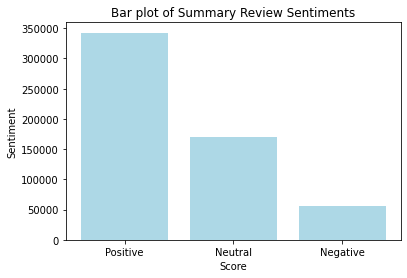

In [ ]:
summary_sentiment_counts = reviews["Summary_sentiment"].value_counts().to_dict()
plt.bar(summary_sentiment_counts.keys(), height=summary_sentiment_counts.values(), color='lightblue')
plt.ylabel('Sentiment')
plt.xlabel('Score')
plt.title('Bar plot of Summary Review Sentiments')
plt.show()

The summary text shows a similar trend as the review text. The interesting difference is that something is casuing this algorithm to give high neutral scores.

We should check if the summary and reviews are correlated. It's expected but would be interesting to see if they are truely correlated.

In [ ]:
spearmanr(reviews["Text_sentiment"], reviews["Summary_sentiment"])

SpearmanrResult(correlation=0.271105244424719, pvalue=0.0)

It seems like sentiment between the text and summary and weakly but significantly correlated.

Finally, we should also check their relationship to the score in case we want to try to model their relationship.

In [ ]:
spearmanr(reviews["Text_sentiment"], reviews["Score"])

SpearmanrResult(correlation=0.38061699756503703, pvalue=0.0)

It seems that the text sentiment is also weakly but significantly correlated to the score.

In [ ]:
spearmanr(reviews["Summary_sentiment"], reviews["Score"])

SpearmanrResult(correlation=0.41804461754622485, pvalue=0.0)

Finally, looking at the summary, we also see a weakly but significant correlation between the summary sentiment and the score. 

#### Engagement of Reviewers

Based on the user id, we should be able understand who the top reviewers are. These people are the most engaged and would likely have high helpfulness due to honing their writing skills.

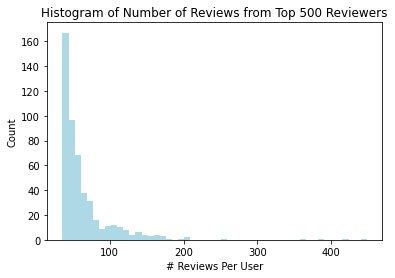

In [ ]:
top_500_reviewers_count = reviews["UserId"].value_counts().nlargest(500)
plt.hist(top_500_reviewers_count, bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Reviews Per User')
plt.title('Histogram of Number of Reviews from Top 500 Reviewers')
plt.show()

As can be seen in the plot above, we can see that from the top 500 reviewers, that the number of reviews are right skewed. Most of the users in this selection have about 30-40 reviews.

over time check if users write longer posts

In [ ]:
top_users = reviews.loc[reviews['UserId'].isin(top_500_reviewers_count.index)]
top_users = top_users.sort_values(["UserId", "Time"])
top_users.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Summary_length,Text_length,Text_sentiment,Summary_sentiment
192071,192072,B000HDEHSQ,A100WO06OQR8BQ,"Duffer. ""Bo""",0,0,3,2007-09-17,Average Taste,Nothing special about this item. Tastes fairly...,NaN,2,23,Negative,Neutral
151158,151159,B001Q9EFW8,A100WO06OQR8BQ,"Duffer. ""Bo""",0,0,5,2009-07-05,Very Good,The first time I gave my dog one of these he s...,NaN,2,60,Positive,Positive
363460,363461,B001Q9EFVY,A100WO06OQR8BQ,"Duffer. ""Bo""",0,0,5,2009-07-05,Very Good,The first time I gave my dog one of these he s...,NaN,2,60,Positive,Positive
395290,395291,B000H7ELTW,A100WO06OQR8BQ,"Duffer. ""Bo""",0,0,5,2009-07-05,Very Good,"These are not very tart, at least not to me. I...",NaN,2,25,Positive,Positive
301744,301745,B001CFMGGI,A100WO06OQR8BQ,"Duffer. ""Bo""",5,9,5,2009-08-11,As Advertized,"Not much to say. It is tart, it is concentrate...",0.555556,2,15,Positive,Neutral


In [ ]:
# Create the numbered entry per person based on sorted list of userid above
review_times_vector = [[j + 1 for j in range(i)] for i in top_500_reviewers_count[top_500_reviewers_count.index.sort_values()]]
review_times_vector_flat = [item for sublist in review_times_vector for item in sublist]

In [ ]:
# Add the numbered review order
top_users["Review_times"] = review_times_vector_flat

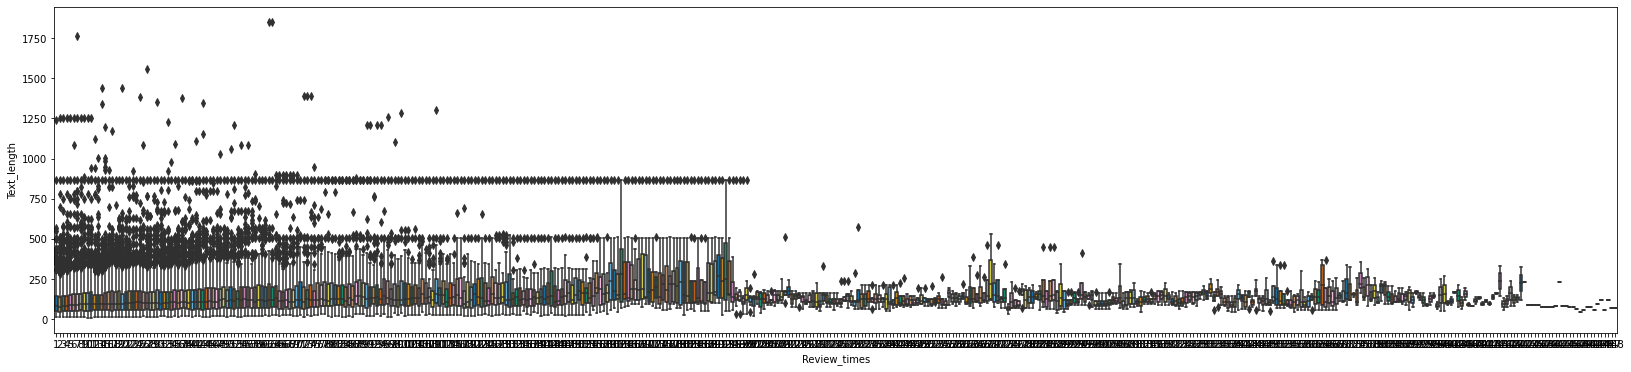

In [ ]:
plt.figure(figsize=(28, 6))
sns.boxplot(y='Text_length', x='Review_times', 
            data=top_users, 
            palette="colorblind")

The box plot above shows the review text length in relation to the number of reviews that person has written so far. We can see two general trends here. In the first half, we can see that the distribution gets wider over time. In the right half, we can see that the box plots mostly shrink as the number of people who write that much get fewer and fewer.

We can look closer between the two and see if there is any meaningful difference.

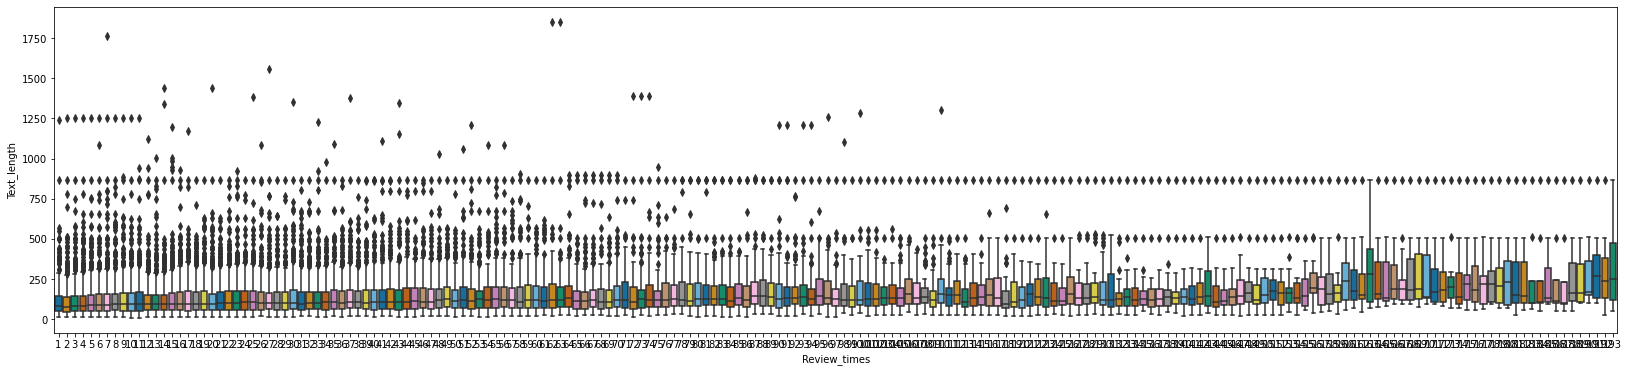

In [ ]:
plt.figure(figsize=(28, 6))
sns.boxplot(y='Text_length', x='Review_times', 
            data=top_users[top_users["Review_times"] < 194], 
            palette="colorblind")

It looks like that the median slowly increases overtime.

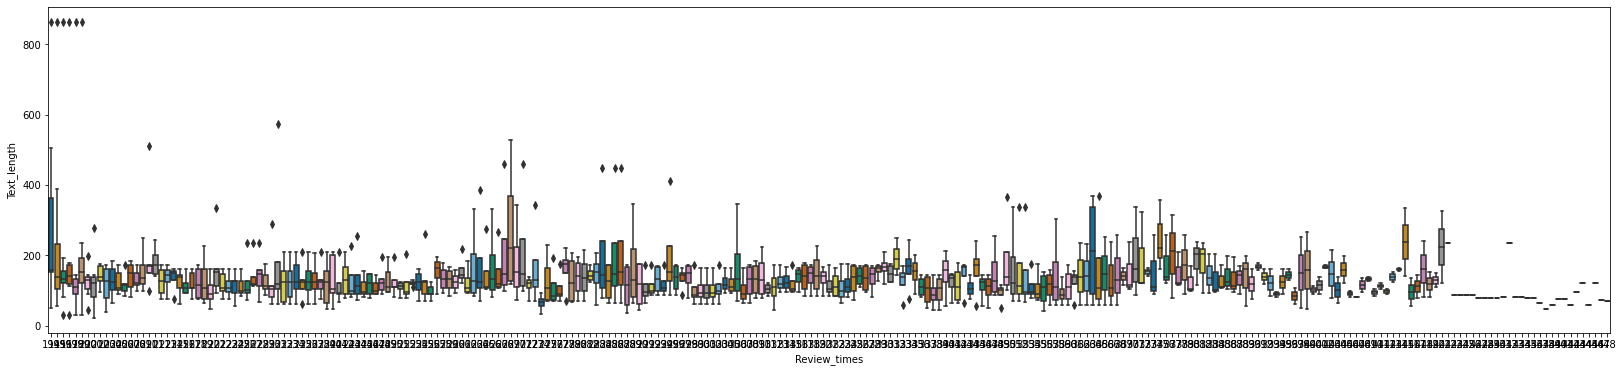

In [ ]:
plt.figure(figsize=(28, 6))
sns.boxplot(y='Text_length', x='Review_times', 
            data=top_users[top_users["Review_times"] >= 194], 
            palette="colorblind")

After 195 reviews, the median begins to drop. This could be sample size problems or it could be that people also get lazy after writing so much.

In [ ]:
text_length_df = top_users.groupby(top_users.Review_times)[['Text_length']].median()
text_length_df.reset_index(level=0, inplace=True)
text_length_df['Review_times'] = pd.to_numeric(text_length_df['Review_times'])
text_length_df

,Review_times,Text_length
0,1,84.0
1,2,78.5
2,3,79.5
3,4,85.0
4,5,86.5
...,...,...
443,444,121.0
444,445,59.0
445,446,121.0
446,447,72.0


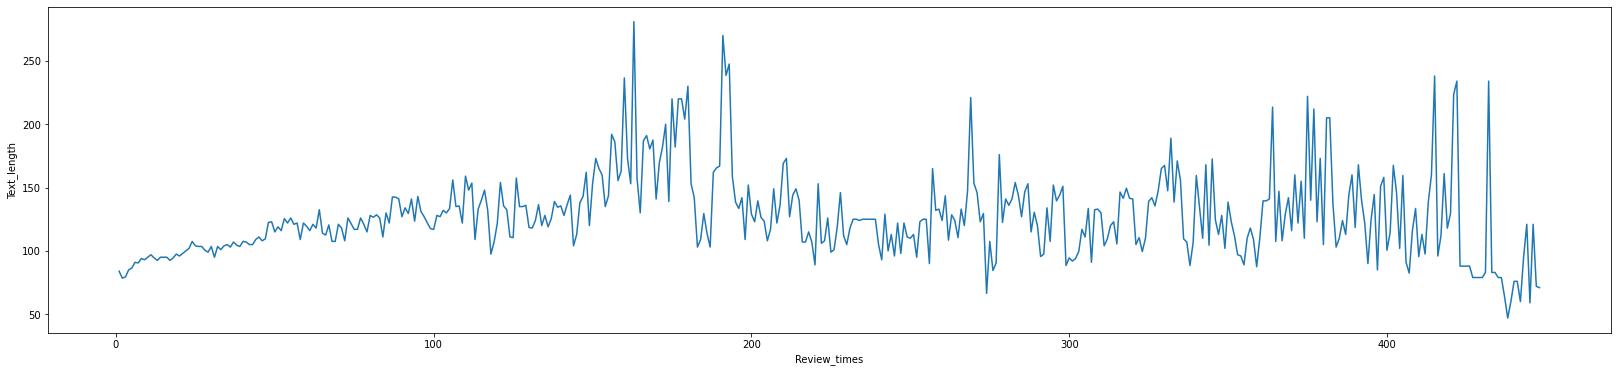

In [ ]:
plt.figure(figsize=(28, 6))
sns.lineplot(y='Text_length', x='Review_times', 
            data=text_length_df)

The plot above shows the trend observed with the box plots. The line represents the median text length over the course of a review's lifetime in the dataset. We can see that the reviews do increase until it fluctuates back down to roughly the initial levels.

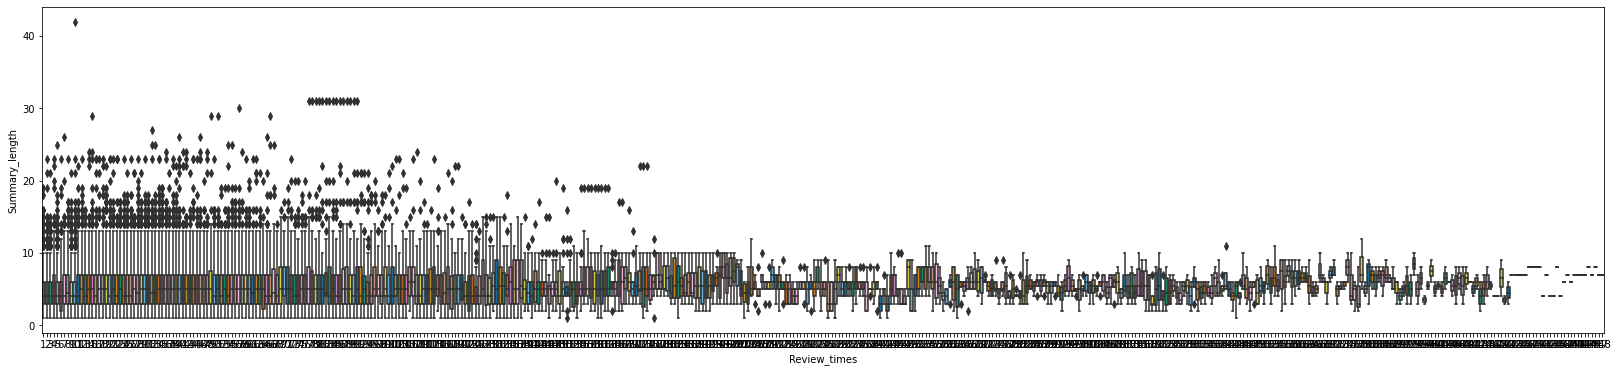

In [ ]:
plt.figure(figsize=(28, 6))
sns.boxplot(y='Summary_length', x='Review_times', 
            data=top_users, 
            palette="colorblind")

The above plot shows the summary text length. We can see that the summary length is relatively consistent for a while inthe beginning and then begins to flucuate. It starts becoming sparse at around 196 reviews as the number of people writing more begins to drop off.

In [ ]:
summary_length_df = top_users.groupby(top_users.Review_times)[['Summary_length']].median()
summary_length_df.reset_index(level=0, inplace=True)
summary_length_df['Review_times'] = pd.to_numeric(summary_length_df['Review_times'])
summary_length_df

,Review_times,Summary_length
0,1,4.0
1,2,4.0
2,3,4.0
3,4,4.0
4,5,4.0
...,...,...
443,444,8.0
444,445,7.0
445,446,8.0
446,447,7.0


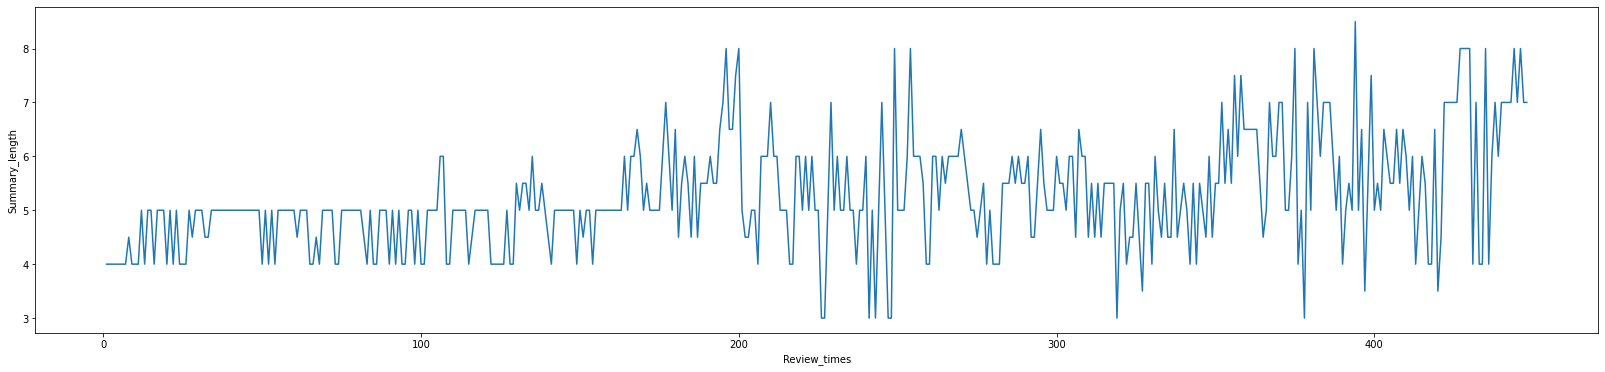

In [ ]:
plt.figure(figsize=(28, 6))
sns.lineplot(y='Summary_length', x='Review_times', 
            data=summary_length_df)

When we do the same thing with the summary length as with the text length, we can see that although it does fluctuate, it seems to actually increase overtime.

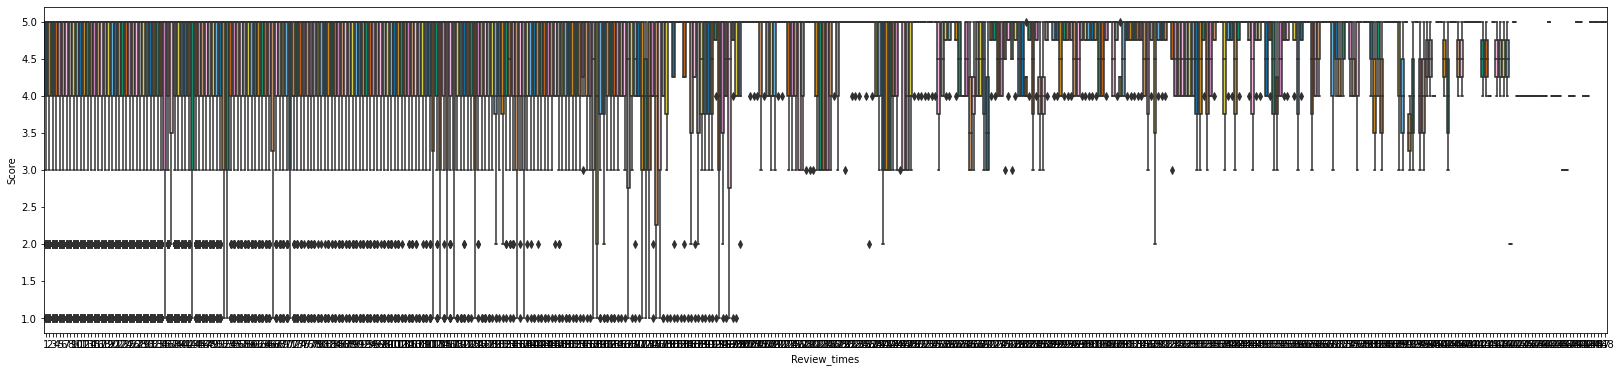

In [ ]:
plt.figure(figsize=(28, 6))
sns.boxplot(y='Score', x='Review_times', 
            data=top_users, 
            palette="colorblind")

The above shows box plots of review by the score. We can see a lot of the effect of having mostly 5 star reviews in the dataset. Most of the Q3 in the box plots are 5 which makes sense and we see sparseness and varying box plots near the end. 

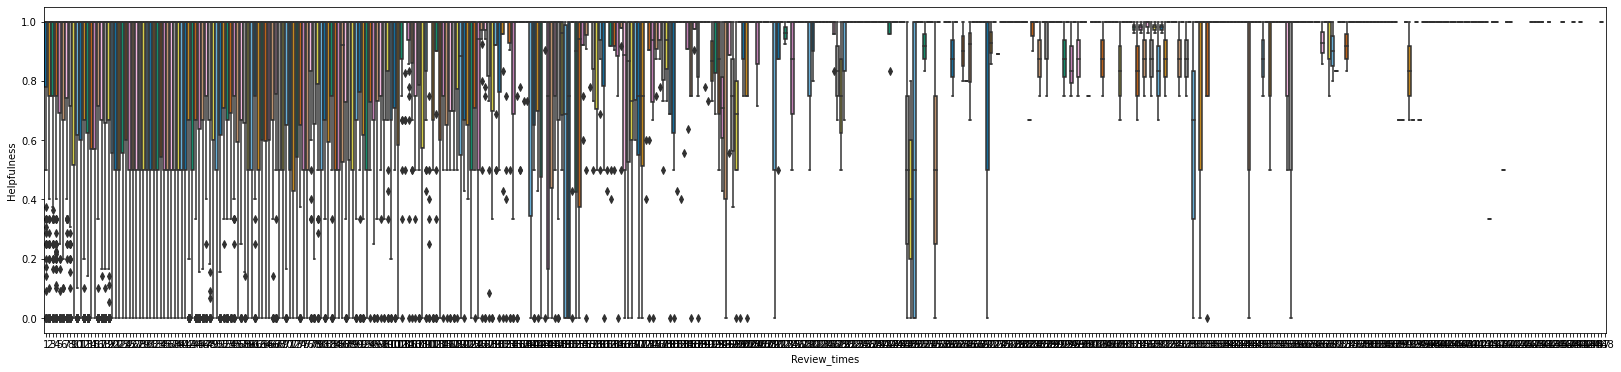

In [ ]:
plt.figure(figsize=(28, 6))
sns.boxplot(y='Helpfulness', x='Review_times', 
            data=top_users, 
            palette="colorblind")

Finally, the plot above is the helpfulness of the reviews. The expectation here is that like people might be more interested in more prolific reviewers and give them more helpful scores. From the box plots shown, there does not seem to be any specific trend but it would make sense if it were more time dependent rather than based on a specific reviewer. 

#### Product Popularity

As we have product id, we can get an estimate of how popular an item is. We can proxy this by number of reviews. 

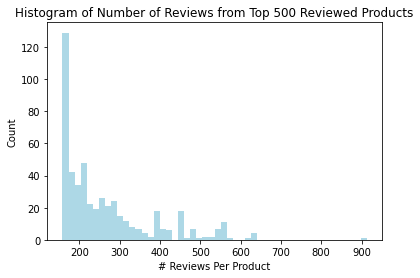

In [ ]:
top_500_product_count = reviews["ProductId"].value_counts().nlargest(500)
plt.hist(top_500_product_count, bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Reviews Per Product')
plt.title('Histogram of Number of Reviews from Top 500 Reviewed Products')
plt.show()

In the plot above, we have the top 500 reviewed products. As expected, the number of reviews are right skewed. We can take a summary look and see what the mean score for these products are and plot it.

In [ ]:
top_products = reviews.loc[reviews['ProductId'].isin(top_500_product_count.index)]
top_products_mean = top_products.groupby('ProductId').mean().filter(["Score", "Helpfulness", "Text_length", "Summary_length"])

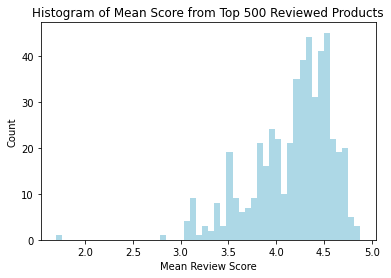

In [ ]:
plt.hist(top_products_mean["Score"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Review Score')
plt.title('Histogram of Mean Score from Top 500 Reviewed Products')
plt.show()

The plot above shows the histogram of the mean score from these top 500 products. We can see that it looks somewhat left skewed and has a multi-modal distribution. We can see that the average stops any product from truly being 5 stars which is expected as we would expect to see some variation in reviews.

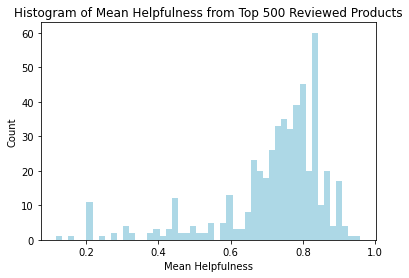

In [ ]:
plt.hist(top_products_mean["Helpfulness"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Helpfulness')
plt.title('Histogram of Mean Helpfulness from Top 500 Reviewed Products')
plt.show()

In the plot above, we can see similar pattern with the helpfulness with the top 500 products. None of the review for these products are truly in concordance with helpfulness in either direction. We get a clear peak at around 0.8 which looks somewhat normal. 

It would be interesting to understand if this helpfulness has some time based dependency. We can calculate relative age of a product based on the last review date and back calculate review metrics and try to visualize these trends.

In [ ]:
# Get the last time per product for date diff
end_time = top_products.groupby('ProductId')['Time'].max()
#end_time = end_time.sort_values('ProductId')

# Find the date diff per review
top_products['Age'] = top_products.apply(lambda d: end_time[d['ProductId']] - d['Time'] , axis=1) / np.timedelta64(1, 'D')



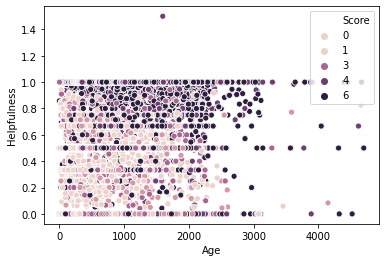

In [ ]:
# Scatter plot the age to helpfulness
sns.scatterplot(x = "Age", y = "Helpfulness", hue="Score", data=top_products)

From this scatter plot, we do see some sort of clustering in the higher bounds after around 100 days with the helpfulness based on age and score. It looks like a lot of the high scored youngish reviews that are generally 5 star also tend to be positively reviewed. It looks like a lot of the reviews for the similar age but lower scores tend to be rated not as helpful. We can try clustering to see if we can better visualize these clusters. It still looks incredibly noisy and there doesn't seem like any specfic trend with the age and helpfulness but maybe we can get lucky with some clustering. First, we should do the histogram of the age to confirm what it looks like.

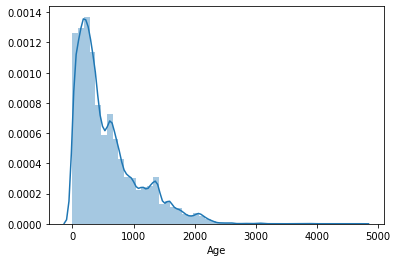

In [ ]:
# Scatter plot the histogram the age and helpfulness
sns.distplot(top_products["Age"])

As seen in the scatter plot above, most of the data is for relatively newer products. These values are generated from the date difference between the date of writing and the oldest review so it stays to reason that a lot of these reviews are relatively newer but still relatively old products. Next, we can try T-Sne to see if we can separate out the helpfulness and the age.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(top_products[['Age', 'Helpfulness']].dropna())

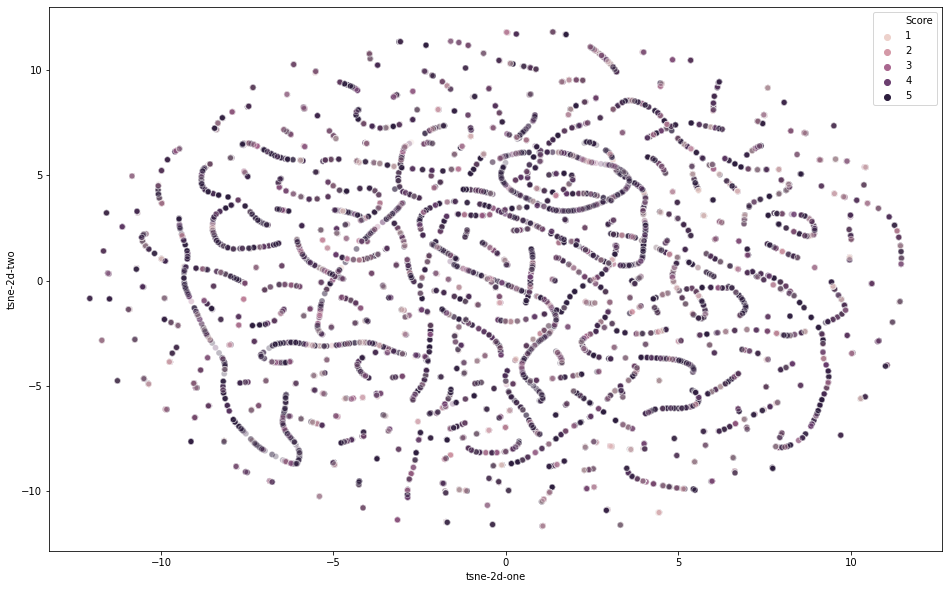

In [ ]:
df_subset = top_products[['Age', 'Helpfulness', 'Score']].dropna()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Score",
    #palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Although interesting looking, there is no clear pattern with TSNE which would suggest that is is hard to separate the features given how much overlap they have with each other.

We can plot the median again as a line plot to try to track trends based on the number of days.

In [ ]:
top_products.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Summary_length,Text_length,Text_sentiment,Summary_sentiment,Age
422,423,B000G6RYNE,A2NO1TXXS9T0EE,BruteNStones,0,0,4,2012-04-26,Hard,"Great if you are cutting back on fat, they do ...",NaN,1,22,Negative,Negative,173.0
423,424,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",0,0,5,2012-04-17,Kettle potato chips: Fully loaded baked potato,I have never met a Kettle brand chip I did not...,NaN,7,51,Positive,Neutral,182.0
424,425,B000G6RYNE,ARONI7W0W677H,Peter N,0,0,5,2012-04-13,"Fresh, Lightly-Spiced, Crunchy Kettle Chips. G...",After buying bags one at a time (at a hefty ma...,NaN,9,141,Positive,Positive,186.0
425,426,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,2012-04-10,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b...",NaN,8,41,Positive,Positive,189.0
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,2012-04-10,"pretty good, could be better",Glad to find these in a one ounce size but the...,NaN,5,52,Positive,Positive,189.0


In [ ]:
age_helpfulness_df = top_products.groupby([top_products.Age, top_products.Score])[['Helpfulness']].mean()
age_helpfulness_df.reset_index(level=0, inplace=True)
age_helpfulness_df.reset_index(level=0, inplace=True)
#age_helpfulness_df['Helpfulness'] = pd.to_numeric(age_helpfulness_df['Helpfulness'])
age_helpfulness_df

,Score,Age,Helpfulness
0,1,0.0,0.833333
1,2,0.0,0.714286
2,3,0.0,0.750000
3,4,0.0,1.000000
4,5,0.0,0.796703
...,...,...,...
7741,1,4660.0,0.826087
7742,5,4670.0,1.000000
7743,5,4676.0,NaN
7744,5,4704.0,0.500000


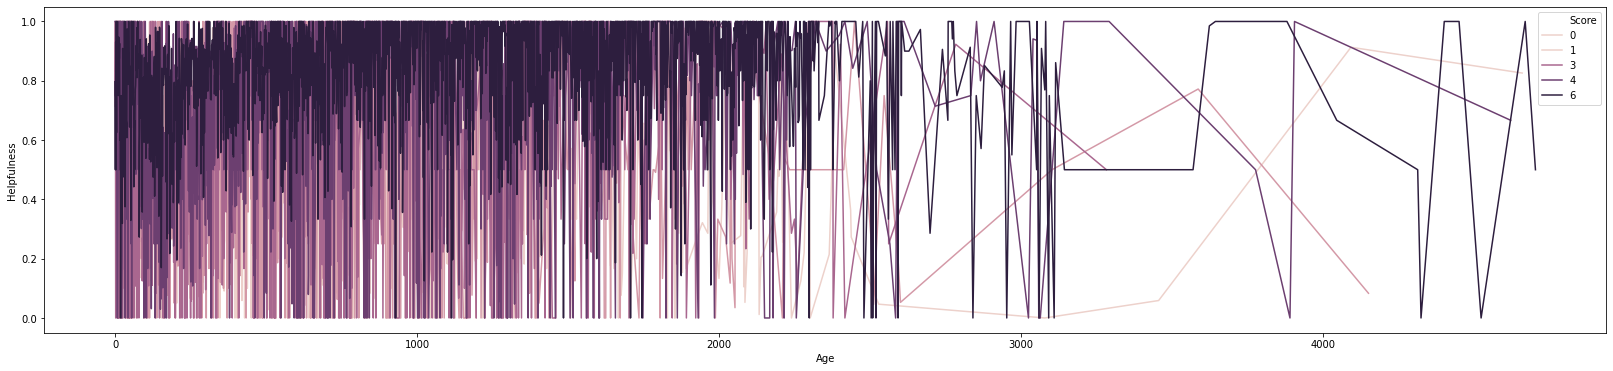

In [ ]:
plt.figure(figsize=(28, 6))
sns.lineplot(y='Helpfulness', x='Age', hue="Score",
            data=age_helpfulness_df)

The plot above shows the line plot of different scores and over time in relation to the mean helpfulness. In general, it looks like we see the mean helpfulness fluctuate but mostly become more positive over time until we start getting sparsity issues with anything past ~2100 days. It looks like the other scores somewhat follow the same pattern and mostly trend upwards overtime until it has sparisity issues as well.

Next, we can look at similar metrics and visualize the mean summary length of the top most reviewed products.

In [ ]:
# Want to try to figure how out to do the helpfulness overtime
end_time = top_products.groupby('ProductId')['Time'].max().reset_index()

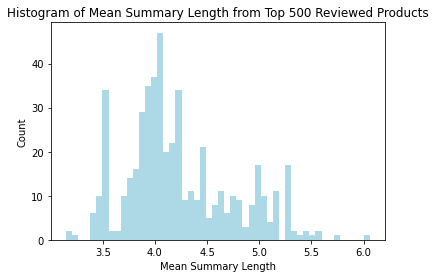

In [ ]:
plt.hist(top_products_mean["Summary_length"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Summary Length')
plt.title('Histogram of Mean Summary Length from Top 500 Reviewed Products')
plt.show()

It looks like the mean summary length is relatively short. It looks more right tailed with the maximum at around 4.

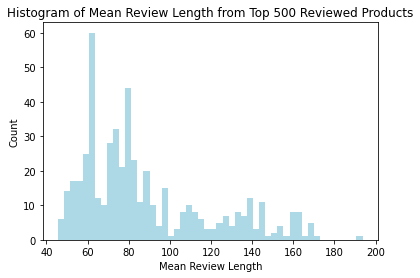

In [ ]:
plt.hist(top_products_mean["Text_length"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Review Length')
plt.title('Histogram of Mean Review Length from Top 500 Reviewed Products')
plt.show()

The mean length seems to vary quite a bit. It seems bimodal at around 55 words and 80 words and then dropping off.

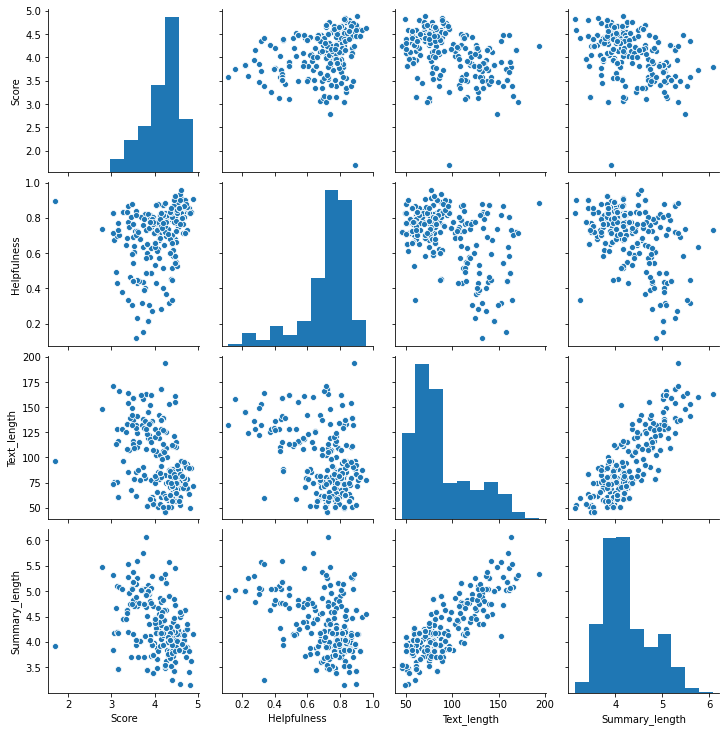

In [ ]:
sns.pairplot(top_products_mean)

Finally, if we look at the pair plot we can see some general trends. The relationship between mean score and the other features are nonlinear. The most interesting relationship is the length of the reviews and the summary which look very strongly correlated. 

#### Review Length

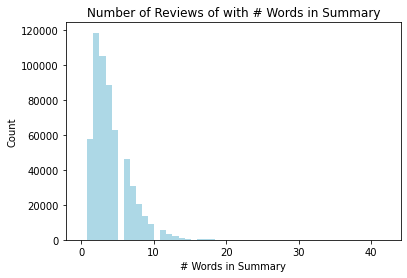

In [ ]:
plt.hist(reviews["Summary_length"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Words in Summary')
plt.title('Number of Reviews of with # Words in Summary')
plt.show()

The plot shows that the summary length is right skewed.

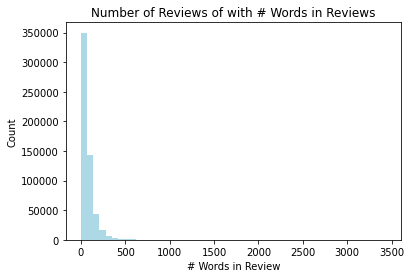

In [ ]:
plt.hist(reviews["Text_length"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Words in Review')
plt.title('Number of Reviews of with # Words in Reviews')
plt.show()

Similar to the summary, we see that the distribution here is right skewed.

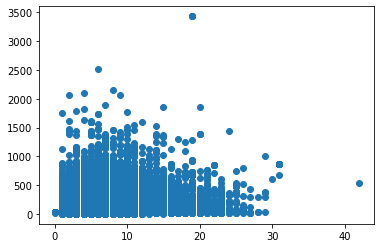

In [ ]:
# Scatter plot of summary length and review length
plt.scatter(reviews["Summary_length"], reviews["Text_length"])
plt.show()

When we plot the two lengths against each other, we can see that there is no obvious relationship between the number of words in summary to review.

In [ ]:
# calculate spearman's correlation
coef, p = spearmanr(reviews["Summary_length"], reviews["Text_length"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.305
Samples are correlated (reject H0) p=0.000


We are interested in seeing if the two variables have any relationship between each other. We can run the spearman correlation as both variables are nonparametric. We can see from above that the correlation is weak but statistically significant in that there is some true relationship between the two variables. 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



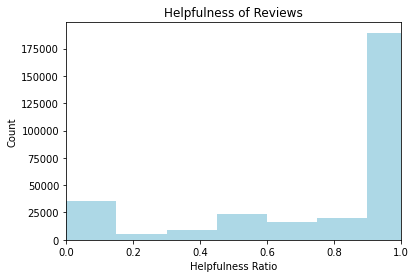

In [ ]:
plt.hist(reviews["Helpfulness"], bins=20, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Helpfulness Ratio')
plt.title('Helpfulness of Reviews')
plt.xlim(0,1)
plt.show()

As can be seen in the plot above, most of the helpful ratio is left skewed. This could be expected as many reviews might have been rated helpful once which would heavily bias this score. We can check this by filtering out the single rated entries.

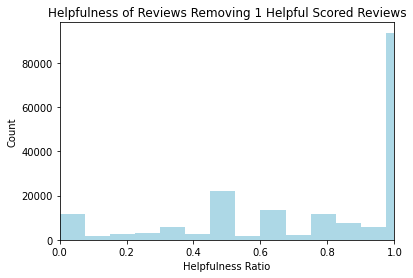

In [ ]:
plt.hist(reviews[reviews["HelpfulnessDenominator"] != 1]["Helpfulness"].dropna(), bins=20, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Helpfulness Ratio')
plt.title('Helpfulness of Reviews Removing 1 Helpful Scored Reviews')
plt.xlim(0,1)
plt.show()

We can see that we get a more interesting pattern here. The above plot shows the same helpfulness ratio but removing all reviews that were scored once. We can see that the number of entries drops by above half. In addition, we still see the left skewed tendencies of this plot.

Finally, we should see how these compare with our scores.

#### Relationship of Score

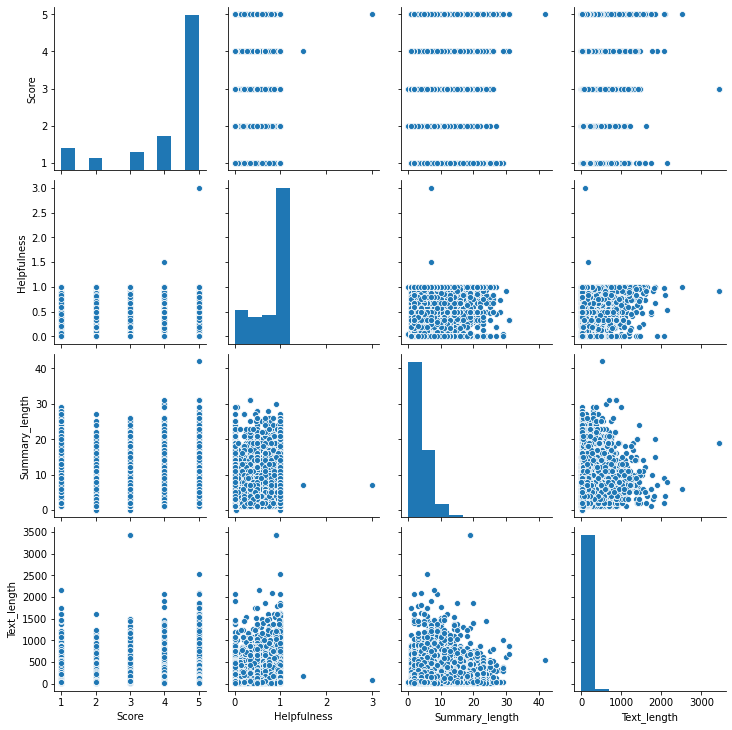

In [ ]:
sns.pairplot(reviews[["Score", "Helpfulness", "Summary_length", "Text_length"]])

Looking at pairwise plots in relation to the score, we can see that none of these features are very clear differentiators to score. We can see that the longer reviews might be a differentiator for higher scores otherwise there is not much signal. We can do a box plot to get a stronger sense of if these numerical variables mean anything.

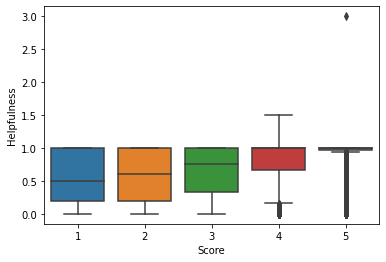

In [ ]:
sns.boxplot(x="Score", y="Helpfulness", data=reviews)

As can be seen in the plot above, Score in relation to the Helpfulness ratio shows patterns in the median. With scores of 4 and 5, we can see the median pushed all the way to almost 1.0. There interestingly are outliers for score 5. We can examine what they are.

In [ ]:
reviews[reviews["Helpfulness"] > 1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Summary_length,Text_length,Text_sentiment,Summary_sentiment
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,2008-06-08,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,1.5,7,184,Positive,Neutral
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,2008-10-25,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,3.0,7,87,Positive,Neutral


This is not expected and it is not clear why the denominator is not the total. It could be a sample collection error.

In [ ]:
from sklearn.preprocessing import minmax_scale

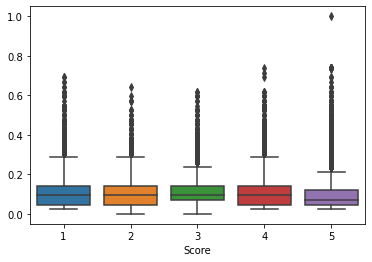

In [ ]:
sns.boxplot(x=reviews["Score"], y=minmax_scale(reviews["Summary_length"]))

The boxplot above shows the score vs the min-max scaled version of the summary length. As we can see, there is not clear pattern between the different scores. We can see that the median and box are tighter in score 5 but as there are more samples, it makes sense.

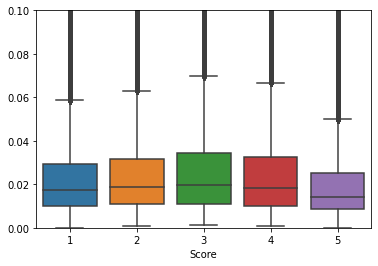

In [ ]:
p1 = sns.boxplot(x=reviews["Score"], y=minmax_scale(reviews["Text_length"]))
p1.set(ylim=(0, 0.1))
p1

We have the box plot of the Score vs the min max normalized version of the text length. The y axis limits are modified otherwise the box is not distinguishable. We can see that the medians are all roughly the same between the different scores. 

Using the non-text variables, it does not seem like any of the features are strong enough to distinguish itself as the primary driver for these review scores. Now, we need to investigate the reviews and summary to see if there is any interesting observations.

#### Reviews and Summary Overview

The bulk of this dataset lies in the Reviews and the summary tagline of the review. There might be something in either of those features which might be interesting for classification. Additionally, it would be interesting to understand those features for general data anlysis to understand the reviewers better.

First, TF-IDF will be calculated high level overview of what these corpus looks like. We will only be checking the unigram for keyword checks and removing stop words, numeric, lemmatization, and removing punctuation. As the number of documents are relatively large, a portion of it will be sampled prior to anallysis.

In [ ]:
reviews_sampled = reviews.sample(12500, random_state = 0) # ~ 3%

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.pipeline import Pipeline
nlp = spacy.load('en')

In [ ]:
def simple_tokenizer(corpus, nlp = nlp):
    """ Give a sentence and return the tokenized string given lemmanization, stop word remove, punctuation removal, and alpha characters only """
    doc = nlp(corpus)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

In [ ]:
#tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer(tokenizer = simple_tokenizer))])
#tfidf_pipe.fit_transform(reviews['Summary'][0:10], reviews['Text'][0:10])

In [ ]:
print("Starting Summary TF-IDF")
tfidf_s = TfidfVectorizer(tokenizer = simple_tokenizer)
tfidf_summary = tfidf_s.fit_transform(reviews_sampled['Summary'])
print("Starting Review TF-IDF")
tfidf_r = TfidfVectorizer(tokenizer = simple_tokenizer)
tfidf_reviews = tfidf_r.fit_transform(reviews_sampled['Text'])

Starting Summary TF-IDF
Starting Review TF-IDF


In [ ]:
tfidf_r.get_feature_names()

['-PRON-',
 'aa',
 'aaa',
 'aaah',
 'aafco',
 'aah',
 'ab',
 'aback',
 'abandon',
 'abba',
 'abbott',
 'abbreviate',
 'abdominal',
 'aberration',
 'abide',
 'ability',
 'abit',
 'able',
 'ably',
 'abnormal',
 'aboard',
 'abomination',
 'aboslutely',
 'abound',
 'abour',
 'abovementione',
 'abra',
 'abroad',
 'abrubt',
 'abrupt',
 'abruptly',
 'absence',
 'absent',
 'absoloutely',
 'absoluely',
 'absoluley',
 'absolute',
 'absolutely',
 'absolutley',
 'absolutly',
 'absorb',
 'absorbent',
 'absorbic',
 'absorbing',
 'absorbtion',
 'absorption',
 'absurd',
 'absurdly',
 'abuelita',
 'abundance',
 'abundant',
 'abundantly',
 'abuse',
 'abysmal',
 'abyssian',
 'abyssinian',
 'acacia',
 'academy',
 'acai',
 'accelerade',
 'accent',
 'accept',
 'acceptable',
 'access',
 'accessibility',
 'accessible',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accidently',
 'acclimate',
 'accommodate',
 'accomodate',
 'accompaniment',
 'accompany',
 'accomplany',
 'accomplish',
 'accord',
 

In [ ]:
# Top 40 tf idf features for reviews
indices = np.argsort(tfidf_s.idf_)[::-1]
features = tfidf_s.get_feature_names()
top_n = 40
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['zym', 'drop', 'drury', 'dubble', 'oi', 'ohmygodisitgoood', 'ohh', 'duct', 'dude', 'duh', 'duo', 'dura', 'durable', 'october', 'oct', 'ocha', 'durian', 'occupy', 'durkee', 'drunk', 'olden', 'obsess', 'oli', 'opal', 'doxy', 'ooey', 'onslow', 'ono', 'dozen', 'dragon', 'onecup', 'drank', 'omit', 'omgoodness', 'omgoah', 'om', 'olympia', 'olvatine', 'olives', 'olively']


The top shows the top 40 tf-idf features from this sample. Although some of these tokens are typos, we can see that the tokens are a mixture of slang for positive things and food related words.

In [ ]:
# Top 40 tf idf features for reviews
indices = np.argsort(tfidf_r.idf_)[::-1]
features = tfidf_r.get_feature_names()
top_n = 40
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['çelem', 'dingy', 'orlando', 'oringinal', 'diminished', 'orignally', 'orignal', 'originator', 'originali', 'dillute', 'dinmont', 'dinnertime', 'origianl', 'dinning', 'dino', 'orginally', 'dimensionally', 'ornament', 'ornish', 'ortho', 'orthopedic', 'orvil', 'dim', 'ospital', 'osteoporosis', 'osterizer', 'othe', 'otherhand', 'othewise', 'othr', 'ottoman', 'ouch', 'oud', 'dinos', 'organo', 'organizing', 'disaponte', 'oprah', 'discernment', 'optimal']


The box above shows the top features for the actual reviews. We can see some typos and some non-english terms. From here, we can mostly see that original and some physical ailments are getting higher TF-IDF values. 

Now that we have a general idea of what the text data looks like, we can go one step further. What would be interesting to gain out of this corpus is to find the top words given each year of reviews in our dataset. It would be interesting to see if we can capture the trend in gourmet foods over the year using the reviews. 

First, we can impute the Score to be binary classifcation using scores of 4-5 as `High` and everything else as `Low`.

In [ ]:
# Binary update the score
reviews['Score_bc'] = reviews['Score'] >= 4
reviews['Score_bc'] = reviews['Score_bc'].astype('category')
reviews.replace({'Score_bc': {True: 'High', False: 'Low'}}, inplace = True)
reviews['Score_bc'].head()

0    High
1     Low
2    High
3     Low
4    High
Name: Score_bc, dtype: object

Next, the goal is to setup scattertext plots of every year of this corpus to get a sense of how things changed over time. To again see which years we have in the dataset, we can do the following:

In [ ]:
pd.DatetimeIndex(reviews['Time']).year.value_counts()

2012    198659
2011    163299
2010     85884
2009     55326
2008     34163
2007     22300
2006      6671
2005      1335
2004       561
2003       132
2002        73
2000        32
2001        13
1999         6
Name: Time, dtype: int64

Now we will create the plots.

In [ ]:
nlp = spacy.load('en')
def produce_scattertext(nlp = nlp, year = 1999, col = "Text"):
    """ Create scattertext based on a given year and text column """
    filtered_reviews = reviews[pd.DatetimeIndex(reviews['Time']).year == year]
    
    print("Creating corpus for " + str(year))
    
    # Turn it into a Scattertext Corpus 
    corpus = st.CorpusFromPandas(filtered_reviews, 
                                 category_col='Score_bc', 
                                 text_col=col,
                                 nlp=nlp).build()
    
    print("Creating plot")
    
    # Output scattertext html files
    html = st.produce_scattertext_explorer(corpus,
                                           category='High',
                                           category_name='High Score',
                                           not_category_name='Low Score',
                                           width_in_pixels=1000,
                                           metadata=filtered_reviews["Score"])
    open("/content/drive/My Drive/kaggle/amazon-fine-food-reviews/output/Score-Visualization" + str(year) + ".html", 'wb').write(html.encode('utf-8'))
    
    print("Finished Scattertext")

In [ ]:
# Create plots (1999 all positive)
produce_scattertext(year = 2000)
produce_scattertext(year = 2001)
produce_scattertext(year = 2002)
produce_scattertext(year = 2003)
produce_scattertext(year = 2004)
produce_scattertext(year = 2005)
produce_scattertext(year = 2006)
produce_scattertext(year = 2007)
produce_scattertext(year = 2008)
produce_scattertext(year = 2009)
produce_scattertext(year = 2010)
produce_scattertext(year = 2011)
produce_scattertext(year = 2012)

Creating corpus for 2000
Creating plot
Finished Scattertext
Creating corpus for 2001
Creating plot
Finished Scattertext
Creating corpus for 2002
Creating plot
Finished Scattertext
Creating corpus for 2003
Creating plot
Finished Scattertext
Creating corpus for 2004
Creating plot
Finished Scattertext
Creating corpus for 2005
Creating plot
Finished Scattertext
Creating corpus for 2006
Creating plot
Finished Scattertext
Creating corpus for 2007
Creating plot
Finished Scattertext
Creating corpus for 2008
Creating plot
Finished Scattertext
Creating corpus for 2009
Creating plot
Finished Scattertext
Creating corpus for 2010
Creating plot
Finished Scattertext
Creating corpus for 2011
Creating plot
Finished Scattertext
Creating corpus for 2012
Creating plot
Finished Scattertext


The goal of creating these scatter text is to get an understand per year of why people gave ratings of 4-5 and why they gave lukewarm or bad reviews of 1-3. We can see several trends when you open up the scatter text. 1999 was not plotted as the sample size was very small and it appears that only highly rated reviews were available. 

* Year 2000 was mostly movie reviews. In particular, people seem to like beetle juice.
* Year 2001 was still related to movies. In particular, people seem to prefer wide screen movies and disliked dvds. Perhaps this is around the rise of dvds as the Playstation 2 was released in 2000.
* Year 2002 is more ambiguous as the top scored words are mostly stop words. It is still movie reviews and makes reference to beetlejuice as well as probably Tim Burton. It also references what is likely the Matrix 2 as some of the actors and actresses are in the dataset. 
* Year 2003 is when the dataset begins to closer mention gourmet foods. It still has movie mentions and some dirty html tags but seems to have high number of chocolate and coffee related terms. Starbucks is specifically mentioned and in 2003, Starbucks bought out the Seattle Coffee Company and expanded about 2000 stores. This is likely a 2nd wave coffee shop trend.
* Year 2004 is a more interesting year. There is still a large influence from Beetlejuice and Tim burton but the two trends here seem to be tea and urinary tract infections and sugar. It seems people are concerned about sugar intake this year. Senseo is also a top characteristic of these reviews and it appears that it started to appear in 2003. Senseo seems like an early Keurig machine designed to simplify coffee using pods. 
* Year 2005 seems to sweets related. We have many interesting terms here including coffee, tea, sweeteners, jarritos, larabar, and kashi. It seems this year is when the health fad happened and people began to worry about the type of sugars in their products. According to wikipedia, 2006 was when the WHO released a report saying stevia was safe for consumption so maybe it is related. In the top scored tokens, chocolate and tea have high scores. Reviews with low score seem to be price and expediated delivery related.
* Year 2006 seems to be dominated by cat food reviews. Looking in the top and low scores, they seem to refer to either cats or dogs and feeding them good food. This might be related to the characteristic terms for kibble and canidae which begun appearing in earlier years. The trends for food according to the characteristics seem relatively similar to 2005. We see more gum, oreos, larabars, teas, pretzels, noodles, and snacks. This might be Amazon deciding to expand their food selection to more unhealthier snacks.
* Year 2007 has more diverse terms. Specifically, the characteristics are more desriptive compared to 2006 which was more specific products. The top scores are mostly relatively positive words that you would expect from reviews like delicious. The low scores are lower sentiment values and are works like disappointed or terrible. There seems to be complaints about pumps and that is related to a water pump for a hydroponic gardening kit from the AeroGarden.
* Year 2008 has many descriptive adjectives. There are still brands that are picked up including izze, canidae but it is mostly generic terms now. The interesting thing is that there seemed to have been some issue with menadione and new formula for canidae which is very poorly received.
* Year 2009 still contained many adjectives. It seems like the Canidae formula changing controversy still continued in the reviews. Interestingly, there seems to be an issue with Made in China this year. Looking at some of the reviews, it seems to be dog treat related.
* Year 2010 continued the trend as seen in the previous years. It seems pasta and snacks became very indicative of high scores. Some of the interesting characteristics that have been added are gluten and keurig which are known for their coffee pods. Investigating the `thought she` which has the top low score shows that there is someone reposting the same negative 1 star review over and over.
* Year 2011 only has Amazon as the only named entity. All of the primary features follow the last couple of year in trends in that it is mostly adjectives. We can see in the plot of high score frequent tokens that we have specific foods people are interested in. There is also interestingly some holistic references including the outlier term `uterus`. The negative reviews seems to be complaints based on expiration or taste.
* Year 2012 shows similar trends as before. We can see that people are still complaining about things made in China. It seems matcha and magnesium are very highly rated. In the plot, we can see certain products people don't seem to like such as hammer products and potentially turbinado sugar. People also seem to be wary of propylene glycol which is a flavorless additive to food. Looking at some of the strange postiive frequent words, we can see that there is review replication such as for `causes diarrhea`.

In summary, plotting scattertext using yearly increments shows more of Amazon's evolution based on this dataset. We can see potentially as a result of contamination, movie reviews. From there, we can see the reviews slowly refine from very specific products into adjectives which describe positive or negative sentiments which are split into the two categories of high and low score. 